# Analyzing a spotify dataset

## Importing libs and reading CSV

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from google.colab import files
from IPython.display import display, HTML, clear_output

In [2]:
uploaded = files.upload()

Saving spotify_data.csv to spotify_data.csv


In [3]:
df = pd.read_csv('spotify_data.csv')

In [4]:
df.head()

,track_id,track_name,track_number,track_popularity,explicit,artist_name,artist_popularity,artist_followers,artist_genres,album_id,album_name,album_release_date,album_total_tracks,album_type,track_duration_min
0,3EJS5LyekDim1Tf5rBFmZl,Trippy Mane (ft. Project Pat),4,0,True,Diplo,77,2812821,moombahton,5QRFnGnBeMGePBKF2xTz5z,"d00mscrvll, Vol. 1",2025-10-31,9,album,1.55
1,1oQW6G2ZiwMuHqlPpP27DB,OMG!,1,0,True,Yelawolf,64,2363438,"country hip hop, southern hip hop",4SUmmwnv0xTjRcLdjczGg2,OMG!,2025-10-31,1,single,3.07
2,7mdkjzoIYlf1rx9EtBpGmU,Hard 2 Find,1,4,True,Riff Raff,48,193302,NaN,3E3zEAL8gUYWaLYB9L7gbp,Hard 2 Find,2025-10-31,1,single,2.55
3,67rW0Zl7oB3qEpD5YWWE5w,Still Get Like That (ft. Project Pat & Starrah),8,30,True,Diplo,77,2813710,moombahton,5QRFnGnBeMGePBKF2xTz5z,"d00mscrvll, Vol. 1",2025-10-31,9,album,1.69
4,15xptTfRBrjsppW0INUZjf,ride me like a harley,2,0,True,Rumelis,48,8682,dark r&b,06FDIpSHYmZAZoyuYtc7kd,come closer / ride me like a harley,2025-10-30,2,single,2.39


## Data Cleaning

In [5]:
# Checking the number of NaN values in the whole dataset

df.isna().sum()

,0
track_id,0
track_name,0
track_number,0
track_popularity,0
explicit,0
artist_name,3
artist_popularity,0
artist_followers,0
artist_genres,3361
album_id,0


**There are 3361 rows without artist genres**

🎯 **Goal: Read artist names via some Spotify API and get their genre(s)**

### Separating artists without genre

In [6]:
# Creating a separated df containing just the artists without genres and their number of followers
artists_without_genre = df[df['artist_genres'].isna()][['artist_name', 'artist_followers']]

# Selecting only artists with at least 10k followers
artists_without_genre = artists_without_genre[(artists_without_genre['artist_followers'] >= 10000)]

# Ordering by number of followers
artists_without_genre.sort_values(by='artist_followers', ascending=False, inplace=True)

display(artists_without_genre.tail())

,artist_name,artist_followers
355,Mandrazo,10272
1665,Prasewon,10229
5667,The Blue Notes,10148
620,Cloud,10130
3288,Olivia Herdt,10100


### Requesting Last.fm API

In [7]:
buffer = artists_without_genre['artist_name'].to_list()
artists_without_genre = []

In [8]:
# Removing duplicates
for artist in buffer:
  if artist not in artists_without_genre:
    artists_without_genre.append(artist)

buffer = []

# Setting URL and defining parameters
url = 'http://ws.audioscrobbler.com/2.0/'
params = {
    'method': 'artist.getinfo',
    'api_key': '548594b2115d6da3efd5d816a0916ef5',
    'format': 'json'
}


read_artist_genres = {}
genres_list = []
read = 0
size = len(artists_without_genre)

for artist in artists_without_genre:
  read += 1
  progress = (100 * read) / size
  display(f'{progress:.1f}% Done ({read} of {size})')
  clear_output(wait=True)
  # display(f"Reading the artist {artist}")
  params['artist'] = artist

  response = requests.get(url, params=params)

  if response.status_code != 200:
    display('Artist not found or error')
    display(response.status_code)
    continue

  data = response.json()

  if 'artist' in data:
    for tags in data['artist']['tags']['tag']:
      # display(f'Artist: {artist} | Tag: {tags['name']}')
      genres_list.append(tags['name'])

  genres_list = ", ".join(genres_list).lower()
  if genres_list:
    read_artist_genres[artist] = genres_list
  genres_list = []


'100.0% Done (991 of 991)'

### Merging with dataset

In [9]:
# Turning dict with artists and genres into a Series to merge with the original DF
read_artist_genres = pd.Series(read_artist_genres)

# Map artists with NaN genres to their corresponding genres
df.loc[df['artist_genres'].isna(), 'artist_genres'] = df['artist_name'].map(read_artist_genres)

### How many artists without genre are left?

In [10]:
df.isna().sum()

,0
track_id,0
track_name,0
track_number,0
track_popularity,0
explicit,0
artist_name,3
artist_popularity,0
artist_followers,0
artist_genres,589
album_id,0


### What can I do to fill the remaining artists with blank genre?

**Trying to find the remaining ones using another API (MusicBrainz):**

In [11]:
artists_without_genre = df[(df['artist_genres'].isna())]['artist_name'].drop_duplicates()

In [12]:
artists_without_genre = artists_without_genre.to_list()

In [13]:
len(artists_without_genre)

404

In [14]:
remaining_artists = {}

from time import sleep

url = 'https://musicbrainz.org/ws/2/artist'

headers = {
    "User-Agent": "MusicAnalytics/0.1 (paulorprocopio@gmail.com)"
}

params = {
    'fmt': 'json'
}


size = len(artists_without_genre)
read = 0

for artist in artists_without_genre:
  read += 1
  progress = (read * 100 / size)
  display(f'{progress:.1f}% Done ({read} of {size})')
  clear_output(wait=True)

  params['query'] = artist
  genres_list = []

  try:
    response = requests.get(url, params=params, headers=headers)

    if response.status_code != 200:
      print('Artist not found or error')
      continue

  except requests.exceptions.ConnectionError as e:
    display('Connection error')
    response = 0

    for retry in range(3):
      display(f'Trying again ({retry + 1})')

      try:
          sleep(0.25)
          response = requests.get(url, params=params, headers=headers)

          if response.status_code == 200:
            display('Successfully read after retry')
            break
      except:
          continue

  if response:
    data = response.json()

    if data['artists']:
      # print('Artist found')
      if 'tags' in data['artists'][0]:
        # print('Artist has at least a tag')
        genres = data['artists'][0]['tags']

        for genre in genres:
          genres_list.append(genre['name'])

        genres_list = ", ".join(genres_list).lower()
        remaining_artists[artist] = genres_list


Artist not found or error


In [15]:
remaining_artists = pd.Series(remaining_artists)
df.loc[df['artist_genres'].isna(), 'artist_genres'] = df['artist_name'].map(remaining_artists)

In [16]:
df.isna().sum()

,0
track_id,0
track_name,0
track_number,0
track_popularity,0
explicit,0
artist_name,3
artist_popularity,0
artist_followers,0
artist_genres,419
album_id,0


## Understanding the dataset

### Does this dataset contains old songs, new songs or both?

In [18]:
# Transforming songs release date to datetime format

df['album_release_date'] = pd.to_datetime(df['album_release_date'])

In [19]:
# Visualizing the release year of the oldest and newest songs, and the  range between them

oldest_song_year = df.sort_values(by="album_release_date")['album_release_date'].dt.year.iloc[0]
newest_song_year = df.sort_values(by="album_release_date")['album_release_date'].dt.year.iloc[-1]
release_date_range = newest_song_year - oldest_song_year

display(HTML(f'The oldest song is from {oldest_song_year}.<br>The newest song is from {newest_song_year}.<br>The range is {release_date_range} years'))





**🎶 Therefore, the dataset contains both old and modern musics.**

### What's predominant, old or modern songs?

<Axes: xlabel='album_release_date', ylabel='Count'>

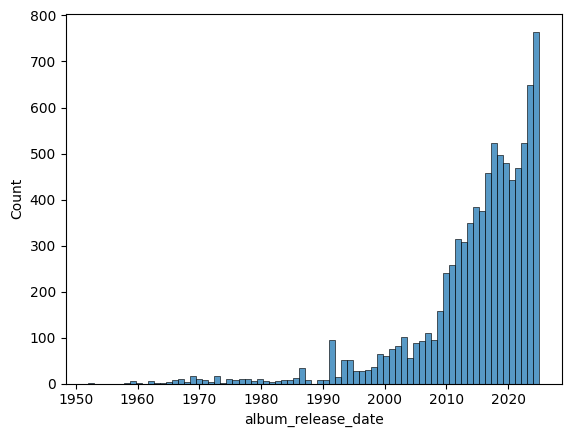

In [20]:
# Creating a histplot to visualize predominant release years

df['album_release_date'] = df['album_release_date'].dt.year
sns.histplot(df, x='album_release_date')

In [21]:
# Visualizing the number of songs per year
display(df['album_release_date'].value_counts().iloc[:10])

,count
album_release_date,
2025,765
2024,648
2023,523
2018,522
2019,496
2020,480
2022,468
2017,458
2021,443


In [22]:
# Calculating the average year of song release

mean_release_date = df['album_release_date'].mean()

display(f"The average release date of songs in this dataset is {mean_release_date:.0f}")

'The average release date of songs in this dataset is 2015'

**Most of the songs are from 2010 - 2020, so modern songs are predominant.**

### How can we measure the success of a track?

In [23]:
# We need to understand how to use the column 'track_popularity' to understand if a song is popular or not
# Maybe it could work as a rating or something? And what's the range of its values?

# Calculating the range
min_popularity = df['track_popularity'].min()
max_popularity = df['track_popularity'].max()
popularity_range = max_popularity - min_popularity

display(HTML(f'The max popularity is {max_popularity}.<br>The min popularity is {min_popularity}<br>The range of song popularity is {popularity_range}'))

So the popularity of tracks goes from 0 to 100.

With it, we can 'adapt' a rating from 0 to 10, just dividing the track's popularity by 10:

In [24]:
df['track_popularity'] /= 10
display((df.sort_values(by='track_popularity', ascending=False).iloc[:10]))


,track_id,track_name,track_number,track_popularity,explicit,artist_name,artist_popularity,artist_followers,artist_genres,album_id,album_name,album_release_date,album_total_tracks,album_type,track_duration_min
457,1CPZ5BxNNd0n0nF4Orb9JS,Golden,4,9.9,False,HUNTR/X,87,3551538,k-pop,14JkAa6IiFaOh5s0nMyMU9,KPop Demon Hunters (Soundtrack from the Netfli...,2025,12,album,3.24
88,3yWuTOYDztXjZxdE2cIRUa,Opalite,3,9.7,False,Taylor Swift,100,145443567,"country, pop, indie, folk",4a6NzYL1YHRUgx9e3YZI6I,The Life of a Showgirl,2025,12,album,3.92
101,1jgTiNob5cVyXeJ3WgX5bL,Elizabeth Taylor,2,9.5,False,Taylor Swift,100,145489371,"country, pop, indie, folk",4a6NzYL1YHRUgx9e3YZI6I,The Life of a Showgirl,2025,12,album,3.47
337,1qbmS6ep2hbBRaEZFpn7BX,Man I Need,1,9.5,False,Olivia Dean,88,1499215,pop soul,0Bv6OJO0L5gcf20DMww54a,Man I Need,2025,3,single,3.06
103,03bTIHJElXZ0O0jqOQvAbY,Father Figure,4,9.4,True,Taylor Swift,100,145542136,"country, pop, indie, folk",4a6NzYL1YHRUgx9e3YZI6I,The Life of a Showgirl,2025,12,album,3.54
1134,6dOtVTDdiauQNBQEDOtlAB,BIRDS OF A FEATHER,4,9.4,False,Billie Eilish,90,118692183,"alternative pop, electropop, dark pop",7aJuG4TFXa2hmE4z1yxc3n,HIT ME HARD AND SOFT,2024,10,album,3.50
450,02sy7FAs8dkDNYsHp4Ul3f,Soda Pop,3,9.4,False,Saja Boys,80,2234812,"k-pop, pop, korean, soundtrack, kpop",14JkAa6IiFaOh5s0nMyMU9,KPop Demon Hunters (Soundtrack from the Netfli...,2025,12,album,2.51
460,1I37Zz2g3hk9eWxaNkj031,Your Idol,7,9.3,False,Saja Boys,80,2234812,"k-pop, pop, korean, soundtrack, kpop",14JkAa6IiFaOh5s0nMyMU9,KPop Demon Hunters (Soundtrack from the Netfli...,2025,12,album,3.19
93,2x3mwb96B6TquRqMtbxUE1,Actually Romantic,7,9.3,True,Taylor Swift,100,145396321,"country, pop, indie, folk",4a6NzYL1YHRUgx9e3YZI6I,The Life of a Showgirl,2025,12,album,2.72
97,5ylJtmaWPJ33cW3En7WOu0,Wood,9,9.3,True,Taylor Swift,100,145443567,"country, pop, indie, folk",4a6NzYL1YHRUgx9e3YZI6I,The Life of a Showgirl,2025,12,album,2.50


## Exploratory Data Analysis (EDA)

### Who are the top artists, and what do they have in common?

In [45]:
# To filter the top artists, I can calculate the song popularity average of their songs, and select only those who have at least two songs on this dataset

# The artists also have a 'artist_popularity' measure which goes from 0 to 100

# Creating a series to get the number of songs by artists (times they appear on dataset)
num_songs_by_artist = df['artist_name'].value_counts()

# Filtering artist with more than one appearance
num_songs_by_artist = num_songs_by_artist[num_songs_by_artist > 1]

# Groupping artist by name and their songs avg. popularity
track_popularity_by_artist = df.groupby(["artist_name"])['track_popularity'].mean().sort_values(ascending=False)

# Groupping by artist name and their songs avg. duration
track_duration_by_artist = df.groupby(["artist_name"])["track_duration_min"].mean()

# Rounding the avg. track duration to 2 decimal places
track_duration_by_artist = round(track_duration_by_artist, 2)

# Getting the artists popularity index of the original DF
artists_popularity_index = df.drop_duplicates(subset='artist_name').set_index('artist_name')['artist_popularity']

# Calculating the number of explicit songs of each artist
number_of_explicit_songs = df[(df['explicit'] == True)]
number_of_explicit_songs = number_of_explicit_songs.groupby(['artist_name'])['explicit'].value_counts()
number_of_explicit_songs = number_of_explicit_songs.droplevel('explicit')

# Getting the artist genres/tags
artists_labels = df.drop_duplicates(subset=['artist_name']).set_index('artist_name')
artists_labels = artists_labels['artist_genres'].str.split(', ')


# Merging the series with number of songs and avg track popularity by artist names
artist_popularity_metrics = pd.DataFrame({
    'number_of_songs': num_songs_by_artist,
    'avg_track_popularity': track_popularity_by_artist,
    'avg_track_duration': track_duration_by_artist,
    'artist_popularity': artists_popularity_index,
    'explicit_songs': number_of_explicit_songs,
    'artist_labels': artists_labels
})

# Ordering by avg track popularity
artist_popularity_metrics = artist_popularity_metrics.dropna(subset=['number_of_songs']).sort_values(by='artist_popularity', ascending=False)

# Rounding the avg track popularity to 2 decimal places
artist_popularity_metrics['avg_track_popularity'] = round(artist_popularity_metrics['avg_track_popularity'], 2)

# Converting the Series number_of_songs and explicit_songs to int (removing decimal place)
artist_popularity_metrics['number_of_songs'] = artist_popularity_metrics['number_of_songs'].astype(int)
artist_popularity_metrics['explicit_songs'] = artist_popularity_metrics['explicit_songs'].fillna(0).astype(int)

# Creating a explicit dependency metric
artist_popularity_metrics['explicit_dependency'] = round((100 * artist_popularity_metrics['explicit_songs']) / artist_popularity_metrics['number_of_songs'], 2)

artist_popularity_metrics.head(15)

,number_of_songs,avg_track_popularity,avg_track_duration,artist_popularity,explicit_songs,artist_labels,explicit_dependency
artist_name,,,,,,,
Taylor Swift,324,6.00,3.90,100,46,"[country, pop, indie, folk]",14.20
Bad Bunny,56,7.33,3.65,95,45,"[reggaeton, trap latino, urbano latino, latin]",80.36
Drake,84,6.59,3.88,95,73,[rap],86.90
The Weeknd,141,6.08,4.38,93,70,"[r&b pop, alternative r&b, hip hop, synthpop]",49.65
Justin Bieber,55,6.63,3.00,91,10,"[pop, contemporary r&b]",18.18
Sabrina Carpenter,34,7.95,3.05,91,23,[pop],67.65
Ariana Grande,94,6.39,3.32,90,39,[pop],41.49
Rihanna,52,6.56,3.88,90,17,"[pop, r&b]",32.69
Billie Eilish,61,7.39,3.50,90,6,"[alternative pop, electropop, dark pop]",9.84


### What are the parameters that make a song popular?

#### How track duration impacts in artists success

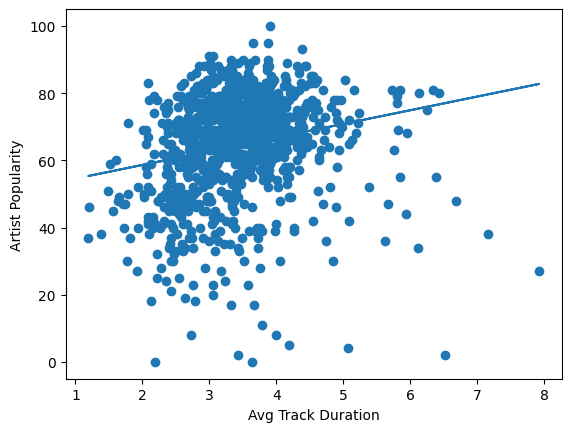

In [ ]:
x = artist_popularity_metrics['avg_track_duration']
y = artist_popularity_metrics['artist_popularity']

fig, ax = plt.subplots()

plt.scatter(x, y)


m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b)

plt.xlabel('Avg Track Duration')
plt.ylabel('Artist Popularity')

plt.show()

Artists with songs averaging between 3 and 4 minutes appear to be more popular, but the relationship is weak.

#### What are the top genres?

**Creating a chart that shows the top genres between the top 100 artists (by artist popularity):**

In [77]:
# Exploded version (with separated labels to plot)
artist_popularity_metrics_exploded = artist_popularity_metrics.explode('artist_labels')
top_100_artists = artist_popularity_metrics_exploded.iloc[:100]

top_100_artists

,number_of_songs,avg_track_popularity,avg_track_duration,artist_popularity,explicit_songs,artist_labels,explicit_dependency
artist_name,,,,,,,
Taylor Swift,324,6.00,3.90,100,46,country,14.20
Taylor Swift,324,6.00,3.90,100,46,pop,14.20
Taylor Swift,324,6.00,3.90,100,46,indie,14.20
Taylor Swift,324,6.00,3.90,100,46,folk,14.20
Bad Bunny,56,7.33,3.65,95,45,reggaeton,80.36
...,...,...,...,...,...,...,...
Olivia Rodrigo,68,6.06,3.05,85,25,alternative pop,36.76
Olivia Rodrigo,68,6.06,3.05,85,25,pop punk,36.76
Daddy Yankee,2,3.75,3.28,85,0,reggaeton,0.00


In [99]:
top_100_artists.loc[(top_100_artists['artist_labels'].str.contains('hip hop')) | (top_100_artists['artist_labels'].str.contains('hip-hop'))] = 'hip hop'
top_100_artists.loc[top_100_artists['artist_labels'].str.contains('pop')] = 'pop'
top_100_artists.loc[top_100_artists['artist_labels'].str.contains('rap')] = 'rap'
top_100_artists.loc[top_100_artists['artist_labels'].str.contains('r&b')] = 'r&b'
top_100_artists.loc[top_100_artists['artist_labels'].str.contains('metal')] = 'metal'
top_100_artists.loc[top_100_artists['artist_labels'].str.contains('rock')] = 'rock'
top_100_artists.loc[top_100_artists['artist_labels'].str.contains('latin')] = 'latin'

top_100_artists_labels = top_100_artists['artist_labels'].value_counts()
other_labels_amount = top_100_artists_labels[(top_100_artists_labels == 1)].sum()
top_100_artists_labels = top_100_artists_labels[(top_100_artists_labels > 1)]
top_100_artists_labels['other'] = other_labels_amount

top_100_artists_labels

,count
artist_labels,
pop,27
rap,15
hip hop,11
r&b,6
latin,6
rock,5
reggaeton,4
rnb,3
country,3


Text(0.5, 1.0, 'Top genres')

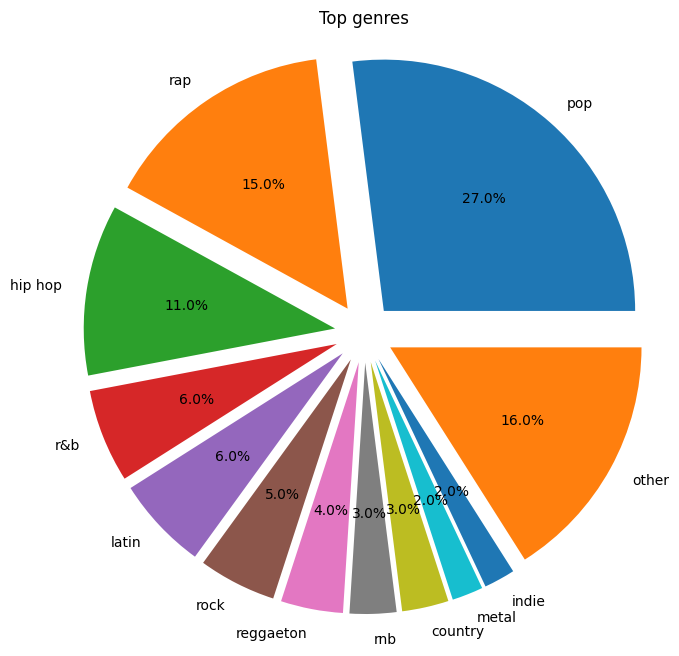

In [118]:
fig, ax = plt.subplots()

labels = top_100_artists_labels.index
percent = top_100_artists_labels

explode = [0.2 for label in top_100_artists_labels.index]

ax.pie(percent, labels=labels, labeldistance=1.1, explode=explode, autopct='%1.1f%%', radius=1.7)
plt.title('Top genres', pad=90)